# Machine Learning 

In the machine learning step, we created a pipeline that used a count vectorizer and the function IDF to transform the data. Then we used a basic logistic regression model to predict if the review was verified or not.  True is equal to one and false is equal to zero. Threshold was change to better fit the imbalanced dataset. Lastly the training data was tested on the model to see how the model was performing. 

### Import pyspark using Docker

In [1]:
import pyspark 
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import matplotlib.pyplot as plt
import numpy as np

### Start Spark Session

In [2]:
spark = SparkSession.builder.appName('ML').getOrCreate()

### Load Data

In [3]:
df = spark.read.csv('clean_train/part-00000-69ff3170-c993-4193-8845-da2e30fd4d60-c000.csv', header = True).select('Text', 'verified')

In [4]:
### View data
df.show(10)

+--------------------+--------+
|                Text|verified|
+--------------------+--------+
|really happy evan...|    true|
|lived west guinea...|    true|
|excellent look co...|   false|
|anything challeng...|    true|
|great movie missi...|    true|
|movie english gre...|    true|
|fascinating true ...|    true|
|appears german en...|    true|
|movie english alt...|    true|
|sorry didnt purch...|    true|
+--------------------+--------+
only showing top 10 rows



After cleaning there was some reviews that didn’t have any words in them. These reviews became null values and they were removes from the training set. 

In [5]:
#### look for nan values 
print('Null Text:', df.where((df["Text"].isNull())).count())
print('Null verified:', df.where((df["verified"].isNull())).count())

Null Text: 63987
Null verified: 0


In [6]:
### drop na's
df = df.na.drop()
df.count()

6942050

We turned they label column that was true/false to a numeric value where one is equal to true and zero is equal to false. 

In [7]:
### create a Label column
df = df.withColumn('label', when(df.verified == 'true', 1.0).otherwise(0.0)).select('Text', 'label')
df.show(10)

+--------------------+-----+
|                Text|label|
+--------------------+-----+
|really happy evan...|  1.0|
|lived west guinea...|  1.0|
|excellent look co...|  0.0|
|anything challeng...|  1.0|
|great movie missi...|  1.0|
|movie english gre...|  1.0|
|fascinating true ...|  1.0|
|appears german en...|  1.0|
|movie english alt...|  1.0|
|sorry didnt purch...|  1.0|
+--------------------+-----+
only showing top 10 rows



### Create & Train Model

In this step of the machine learning process a pipeline was created to transform the data into the format needed to input values in to the logistic regression model. We used TD-IDF to turn the words in to a numeric format. Once data was in the right format a basic logistic regression model was trained on the training data. After training was done the ROC curve was examined and the f-measure vs. different thresholds was also examined. From this information the threshold for predicting a one was increased from .50 to .61.

In [8]:
from pyspark.ml.feature import Tokenizer, CountVectorizer,StringIndexer, RegexTokenizer, IDF, StandardScaler
from pyspark.ml.classification import LogisticRegression,LogisticRegressionModel
from pyspark.ml import Pipeline

In [9]:
### Create pipeline 
tokenizer = Tokenizer(inputCol="Text", outputCol="token_text")
countVectors = CountVectorizer(inputCol="token_text", outputCol="rawFeatures")
idf = IDF(inputCol="rawFeatures", outputCol="idf")
ss = StandardScaler(inputCol='idf', outputCol='features')
pipeline = Pipeline(stages=[tokenizer, countVectors,idf, ss])

In [10]:
### fit pipeline to data
pipelineFit = pipeline.fit(df)

In [11]:
#### create dataset for training of model 
train = pipelineFit.transform(df)
train.show(10)

+--------------------+-----+--------------------+--------------------+--------------------+--------------------+
|                Text|label|          token_text|         rawFeatures|                 idf|            features|
+--------------------+-----+--------------------+--------------------+--------------------+--------------------+
|really happy evan...|  1.0|[really, happy, e...|(262144,[0,2,7,9,...|(262144,[0,2,7,9,...|(262144,[0,2,7,9,...|
|lived west guinea...|  1.0|[lived, west, gui...|(262144,[6,11,55,...|(262144,[6,11,55,...|(262144,[6,11,55,...|
|excellent look co...|  0.0|[excellent, look,...|(262144,[0,51,52,...|(262144,[0,51,52,...|(262144,[0,51,52,...|
|anything challeng...|  1.0|[anything, challe...|(262144,[54,95,11...|(262144,[54,95,11...|(262144,[54,95,11...|
|great movie missi...|  1.0|[great, movie, mi...|(262144,[0,2,34,7...|(262144,[0,2,34,7...|(262144,[0,2,34,7...|
|movie english gre...|  1.0|[movie, english, ...|(262144,[0,2,58,2...|(262144,[0,2,58,2...|(2621

In [12]:
### Bulding model 
lr = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0, family = "binomial")
lrModel = lr.fit(train)

In [13]:
### Summary of model training
train_Summary = lrModel.summary

In [14]:
### ROC
print('AUC:', str(train_Summary.areaUnderROC))

AUC: 0.799974105910763


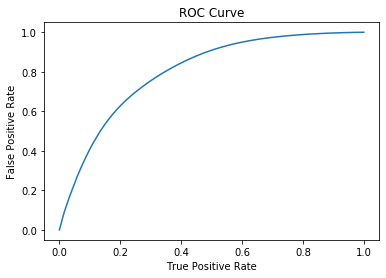

In [15]:
roc = train_Summary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

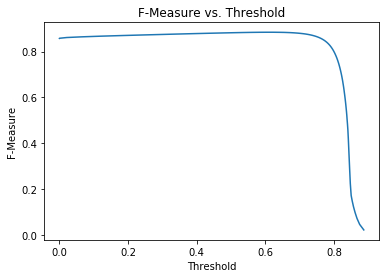

In [16]:
f = train_Summary.fMeasureByThreshold.toPandas()
plt.plot(f['threshold'],f['F-Measure'])
plt.ylabel('F-Measure')
plt.xlabel('Threshold')
plt.title('F-Measure vs. Threshold')
plt.show()

In [17]:
### threshold
lr.getThreshold()

0.5

In [18]:
### Best f1 score to get threshold
fMeasure = train_Summary.fMeasureByThreshold
maxFMeasure = fMeasure.groupBy().max('F-Measure').select('max(F-Measure)').head()
print('Best F1 score:', str(maxFMeasure[0]))
bestThreshold = fMeasure.where(fMeasure['F-Measure'] == maxFMeasure['max(F-Measure)'])\
.select('threshold').head()['threshold']
print('Best threshold:',bestThreshold )

Best F1 score: 0.8841971533583828
Best threshold: 0.6047017922446718


In [19]:
### set new threshold
lr.setThreshold(bestThreshold)
lr.getThreshold()

0.6047017922446718

### Test on training data

With the new threshold implemented in the model the training data was used to make predictions to get a baseline view of how the model is preforming. 

In [20]:
### Predict using train
pred = lrModel.transform(train)

In [21]:
pred.select('label', 'prediction', 'probability').show(10)

+-----+----------+--------------------+
|label|prediction|         probability|
+-----+----------+--------------------+
|  1.0|       1.0|[0.15852012758061...|
|  1.0|       1.0|[0.19654454281587...|
|  0.0|       1.0|[0.28523866587382...|
|  1.0|       1.0|[0.17592178645724...|
|  1.0|       1.0|[0.18895417481023...|
|  1.0|       1.0|[0.16431389991430...|
|  1.0|       1.0|[0.21777641333774...|
|  1.0|       1.0|[0.17065816919017...|
|  1.0|       1.0|[0.16592594339755...|
|  1.0|       1.0|[0.14375257663048...|
+-----+----------+--------------------+
only showing top 10 rows



### Evaluate Model

To evaluate the model we looked at ROC, accuracy, and f1 score. All three metrics showed that the model is doing pretty well on the training dataset which is expected.  

In [22]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [23]:
#### R0C
evaluator = BinaryClassificationEvaluator()
print('Train Area Under ROC', evaluator.evaluate(pred))

Train Area Under ROC 0.8000131871226264


In [24]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
### can get the f1 score, accuracy, precision and recall using MulticlassClassificationEvaluator 

In [25]:
#### Accuracy 
acc = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='label', metricName='accuracy')
acc.evaluate(pred)

0.8036510828933816

In [26]:
#### F1 Score 
ff = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='label', metricName='f1')
ff.evaluate(pred)

0.7658786743209146

### Save model & pipeline 

The model and pipeline were saved to be used in the validation and test step.

In [27]:
### save pipeline 
pipelineFit.write().overwrite().save("pipline_train")

In [28]:
### save fitted model 
lrModel.save('LGmodel')